<center>

*******************************************************************************************

### Phase-Locking Value

##### 12 March 2025

##### Juan Ignacio Mendoza Garay

*******************************************************************************************

</center>

##### INFORMATION:

* "Phase-locking value" (PLV) is a measure for synchrony of two or more periodic or recurrent signals. In this context, synchrony is defined as a stable phase difference, either in a short lapse of time, or across a number of trials or conditions. The program below evaluates PLV upon a window in time.

>
* References:

    * Lachaux, J. P., Rodriguez, E., Martinerie, J., & Varela, F. J. (1999). Measuring phase synchrony in brain signals. *Human brain mapping, 8*(4), 194-208. https://doi.org/10.1002/(SICI)1097-0193(1999)8:4%3C194::AID-HBM4%3E3.0.CO;2-C

    *  Mormann, F., Lehnertz, K., David, P., & Elger, C. E. (2000). Mean phase coherence as a measure for phase synchronization and its application to the EEG of epilepsy patients. *Physica D: Nonlinear Phenomena, 144*(3-4), 358-369. https://doi.org/10.1016/S0167-2789(00)00087-7

    * Bruña, R., Maestú, F., & Pereda, E. (2018). Phase locking value revisited: teaching new tricks to an old dog. *Journal of neural engineering, 15*(5), 056011. https://doi.org/10.1088/1741-2552/aacfe4
>
* Instructions:

    Edit the values indicated with an arrow like this: <---

*******************************************************************************************

In [1]:
import sys

import numpy as np
import pandas as pd

sys.path.append(r"..\src")
from syncoord import sc_ptdata, sc_ndarr

***
### Generate synthetic data

index; Name; duration:
  0; Test Data; 0:21



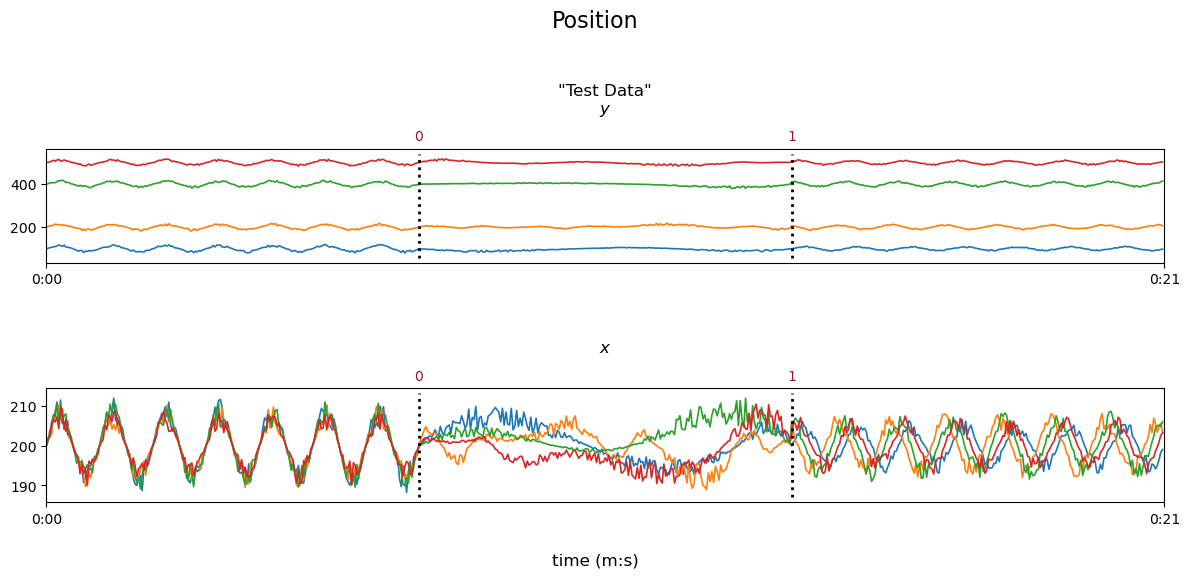

In [2]:
position = sc_ptdata.position( 'make', print_durations=True )
sc_ptdata.visualise( position, vscale=1.2, dlattr='1.2'  )

***
### Low-Pass Filter

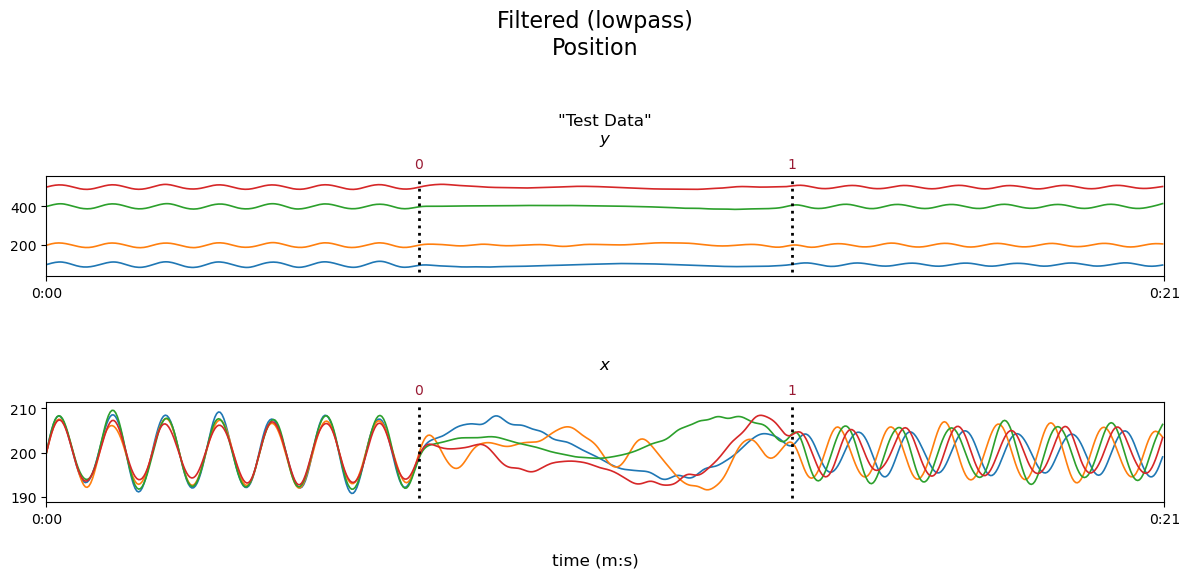

In [3]:
apply_LPF = True # <---

filter_type = 'butter'
filter_freq_response = 'lowpass'
filter_cutoff_freq = 2 # <--- (Hz)
filter_order = 3       # <---

if apply_LPF:
    smooth_pos = sc_ptdata.smooth( position, filter_type=filter_type,
                                   freq_response=filter_freq_response,
                                   cutoff_freq=filter_cutoff_freq, order=filter_order )
    sc_ptdata.visualise( smooth_pos, vscale=1.2, dlattr='1.2'  )
else:
    smooth_pos = position
    print('Filter not applied.')

***
### Speed

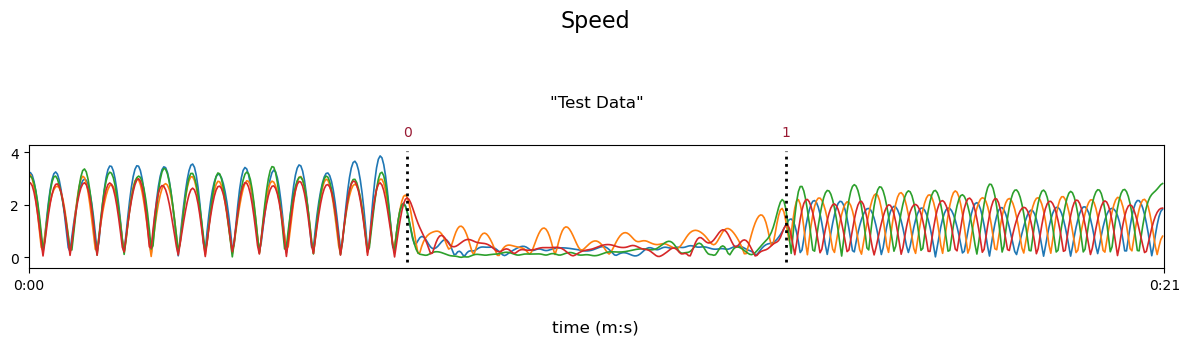

In [4]:
speed = sc_ptdata.apply( smooth_pos, sc_ndarr.tder2D )
sc_ptdata.visualise( speed, vscale=1.4, dlattr='1.2' )

***
### Phase

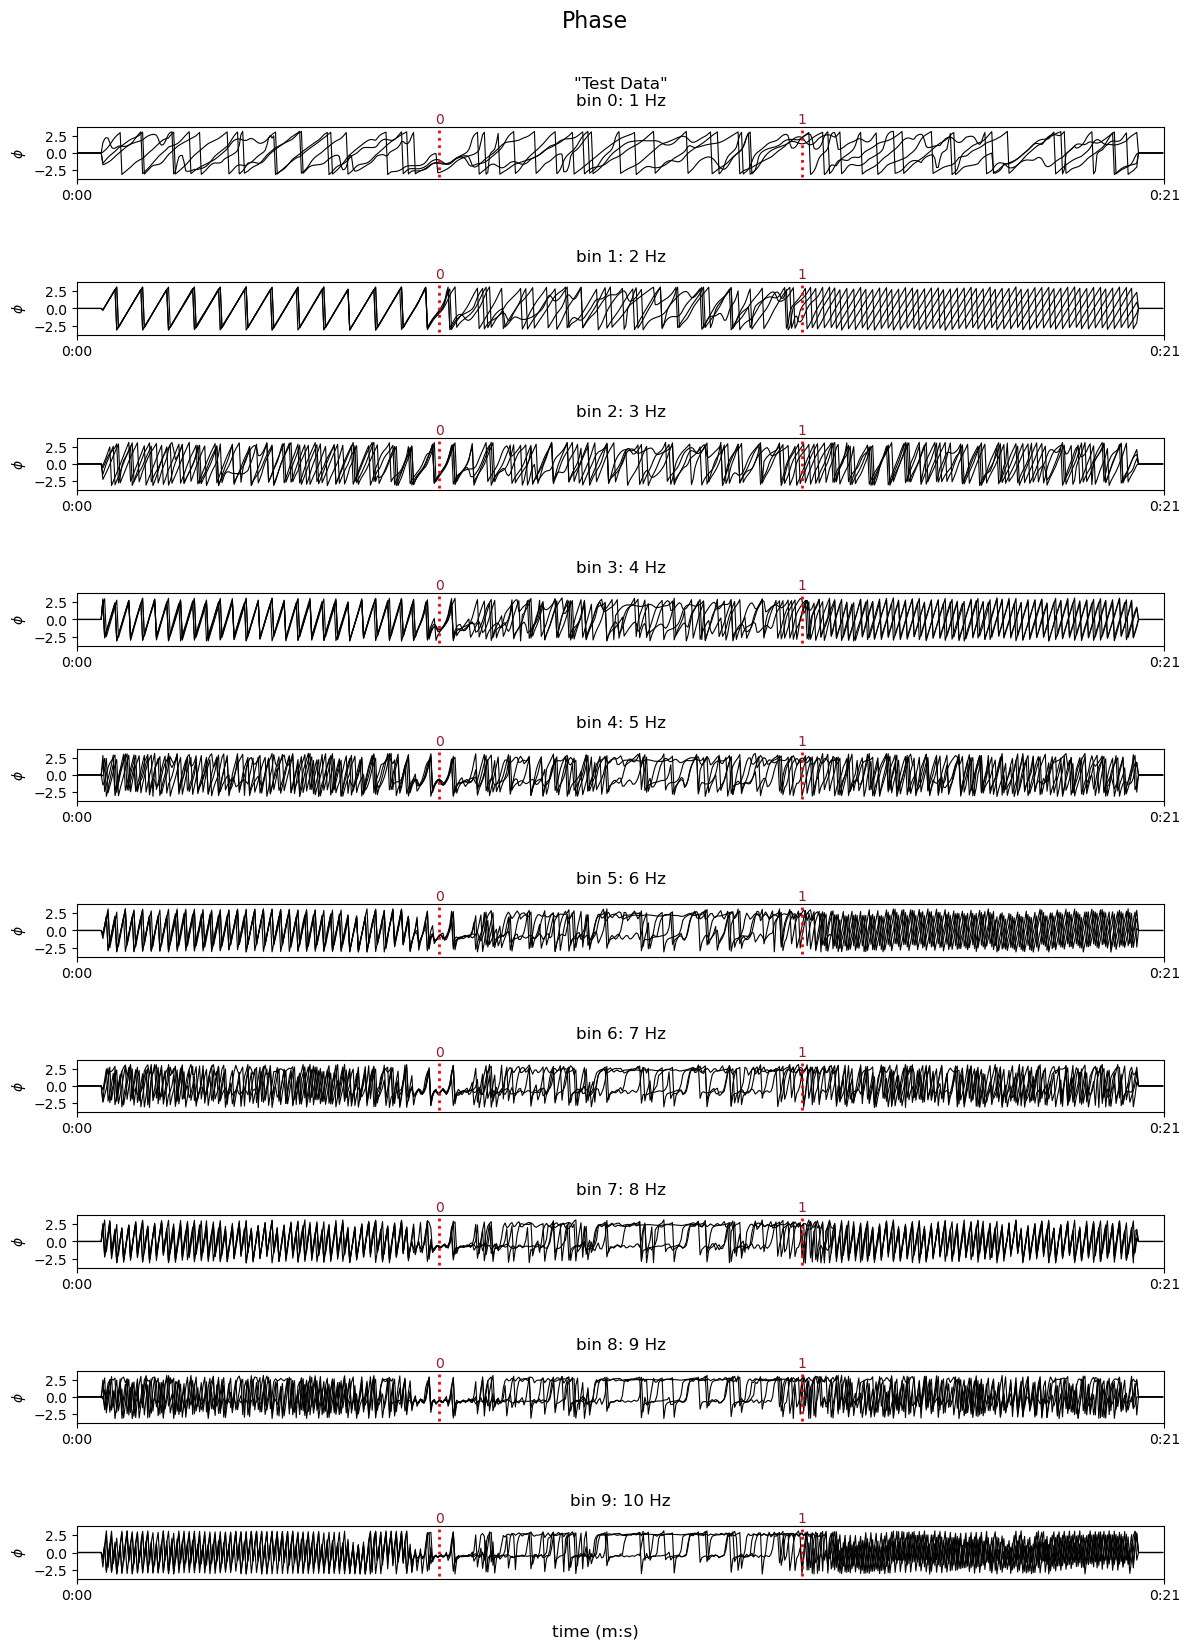

In [5]:
fft_window_s = 1           # <--- FFT window's length (seconds)
sel_freq_bin = slice(0,10) # <--- select frequency bins (int, slice, or 'all')

fft_phase = sc_ptdata.fourier( speed, fft_window_s, output='phase' )
if sel_freq_bin == 'all':
    sc_ptdata.visualise( fft_phase, vscale=0.7 )
else:
    fft_phase = sc_ptdata.select(fft_phase,frequency=sel_freq_bin)
    if isinstance(sel_freq_bin,slice): sc_ptdata.visualise( fft_phase, vscale=0.7 )
    else: sc_ptdata.visualise( fft_phase, vscale=1.3 )

>
### PLV for each pair:

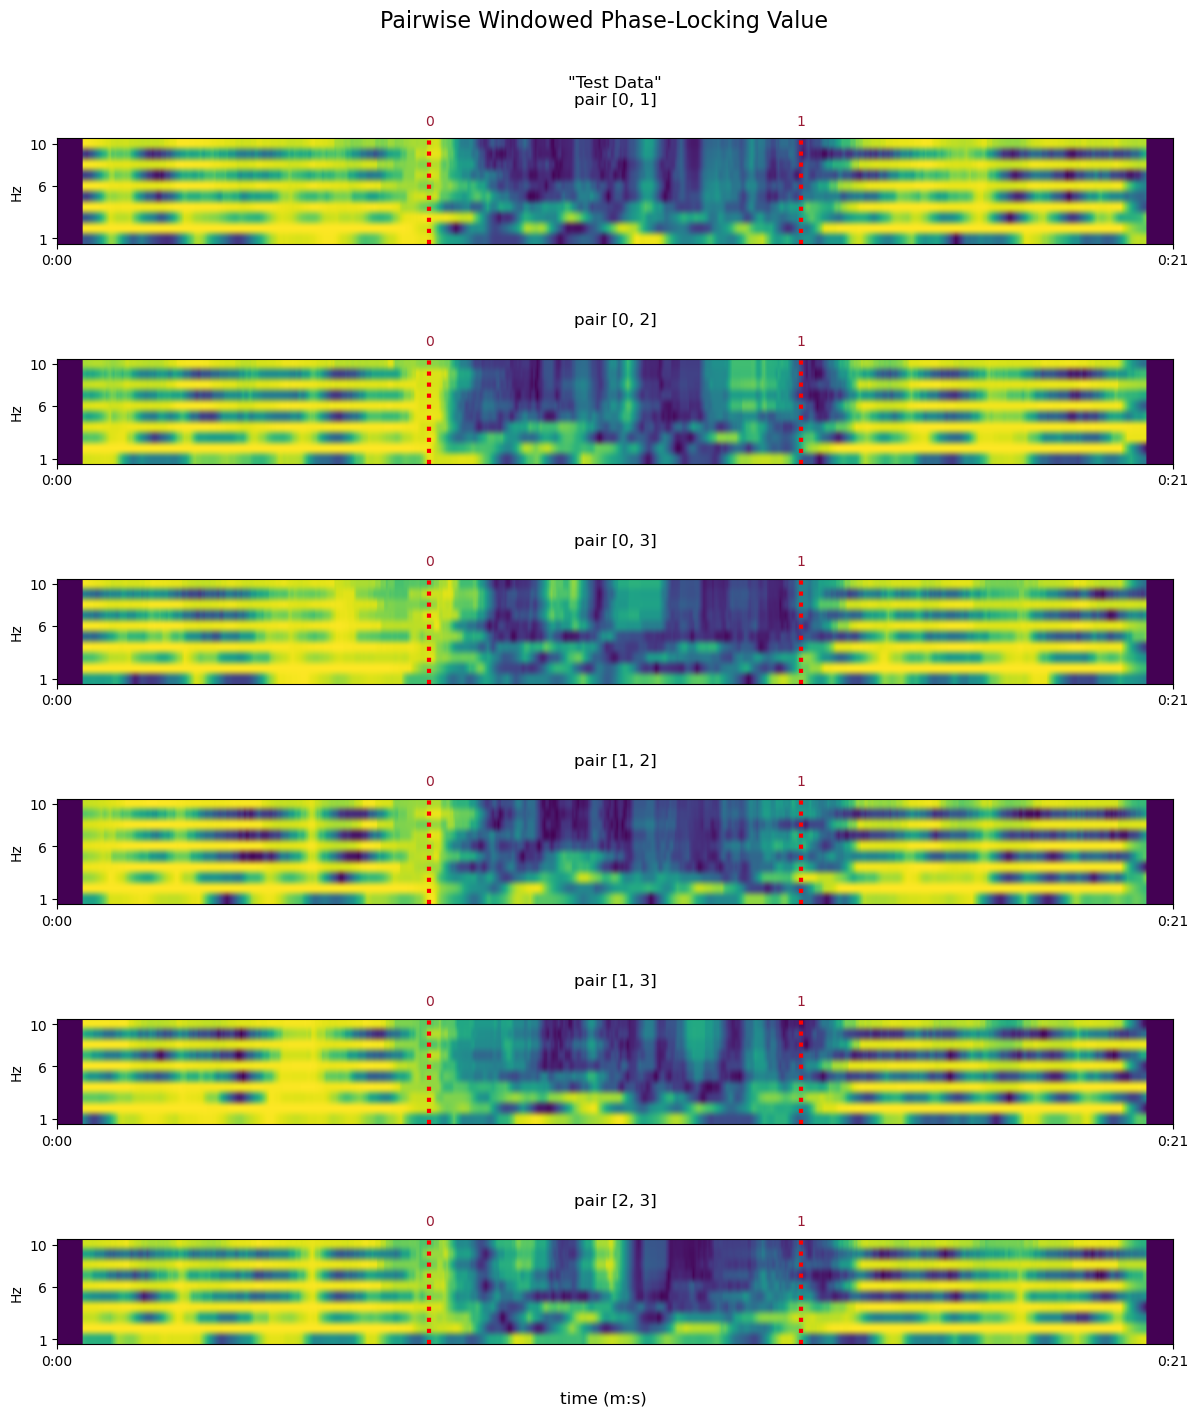

In [6]:
plv_window = 1 # <--- (seconds)

wplv = sc_ptdata.winplv( fft_phase, plv_window )
sc_ptdata.visualise( wplv, dlattr='1.2' )

>
### Average PLV for group:

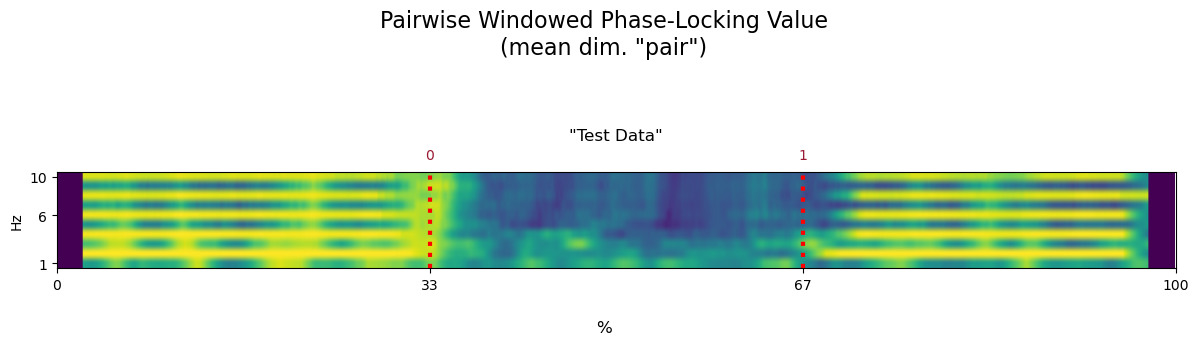

In [7]:
wplv_aggr_pairs = sc_ptdata.aggrax( wplv, axis=0, function='mean' )
sc_ptdata.visualise( wplv_aggr_pairs, vscale=1.4, dlattr='1.2' )

>
### Average band-average PLV for group:

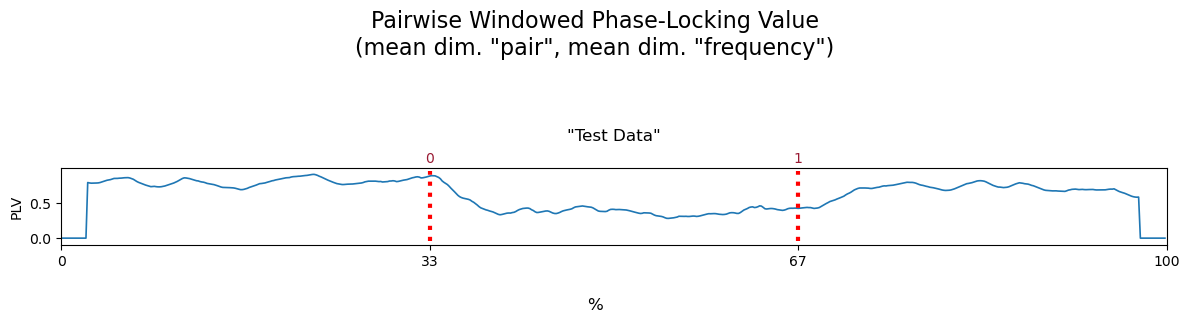

In [8]:
if isinstance(sel_freq_bin,int):
    print('Process does not apply.')
else:
    wplv_aggr_top_sel = sc_ptdata.aggrax( wplv_aggr_pairs, axis=0, function='mean' )
    sc_ptdata.visualise( wplv_aggr_top_sel, vscale=1.3, vistype='line', dlattr='1.2' )